In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [4]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.py')

In [5]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 1.75 s, sys: 3.32 s, total: 5.07 s
Wall time: 5.1 s


In [6]:
df.shape

(6582476, 54)

In [7]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 0 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.4 GB


In [8]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [9]:
testx=df[df.index<10000000].drop('target',axis=1)
testx.shape

(1378521, 53)

In [10]:
df=df[df.index>=10000000]

In [11]:
df.shape

(5203955, 54)

In [12]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203955 entries, 10000000 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.1 GB


In [13]:
df=df.loc[np.random.permutation(df.index)]

In [14]:
import gc
gc.collect()

11694

In [15]:
df.head()

market       f_0       f_1       f_2       f_3       f_4  \
id                                                                     
14754375  4.751840  4.084971  4.715542  4.610031  1.154096  0.000000   
12255550  5.310967  4.786207  4.589514  4.622002  1.453079  1.113149   
10490953  4.266003  4.357457  4.589514  4.576220  1.129340  0.000000   
11060648  4.494233  4.682021  4.589514  4.610031  1.006695  1.043294   
14923170  4.659936  4.682021  4.589514  4.622002  0.785506  0.732306   

               f_5  f_6       f_7       f_8    ...     latest_target   count  \
id                                             ...                             
14754375  4.191009  0.0  5.085581  1.001795    ...           -9999.0 -9999.0   
12255550  5.681114  0.0  5.055375  1.043118    ...               7.0     5.0   
10490953  3.457174  0.0  4.385122  1.276678    ...           -9999.0 -9999.0   
11060648  4.191009  0.0  4.030138  1.001795    ...               4.0     3.0   
14923170  2.081243  0.0  4.183275  1.253745    ...           -9999.0 -9999.0   

                 freq  latest3_mean  changed_count  latest2_change  \
id                                                                   
14754375 -9999.000000       -9999.0        -9999.0         -9999.0   
12255550     0.833333          43.0            4.0             3.0   
10490953 -9999.000000       -9999.0        -9999.0         -9999.0   
11060648     0.750000          43.0            2.0            -1.0   
14923170 -9999.000000       -9999.0        -9999.0         -9999.0   

          latest2_mean    mkt_mean  mkt_count  id_count  
id                                                       
14754375       -9999.0 -9999.00000    -9999.0   -9999.0  
12255550          55.0     4.45000        3.0      10.0  
10490953       -9999.0     2.26667        3.0      13.0  
11060648          45.0     4.66667        2.0       7.0  
14923170       -9999.0 -9999.00000    -9999.0   -9999.0  

[5 rows x 54 columns]

market


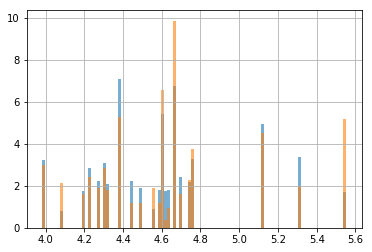

age


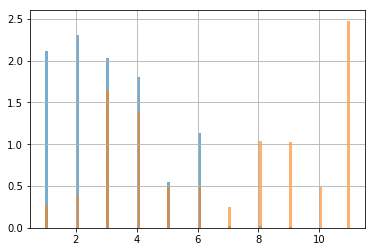

latest_target


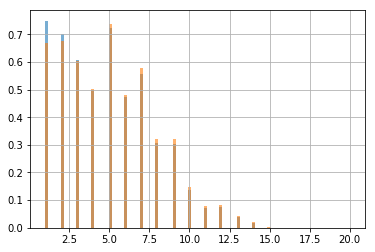

count


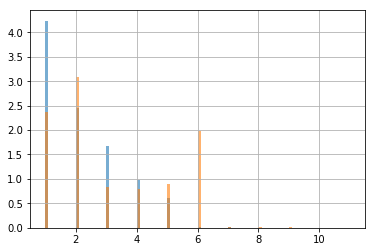

freq


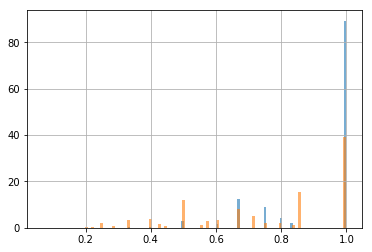

latest3_mean


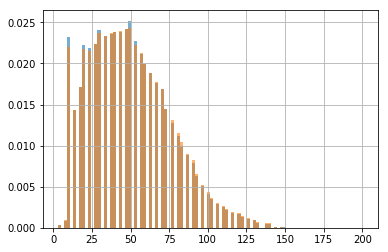

changed_count


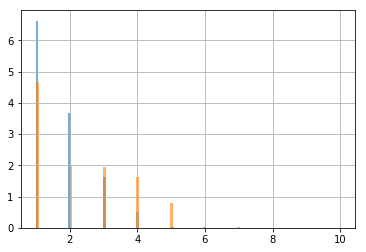

latest2_change


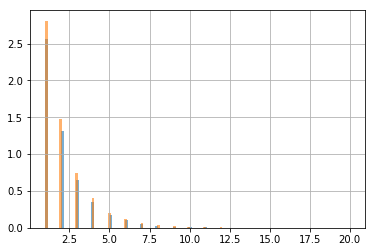

latest2_mean


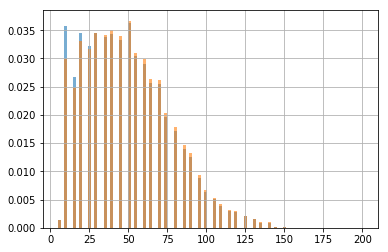

mkt_mean


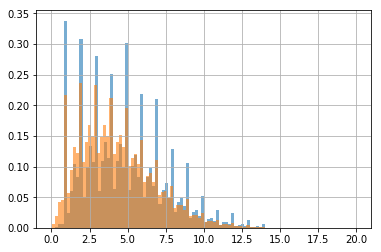

mkt_count


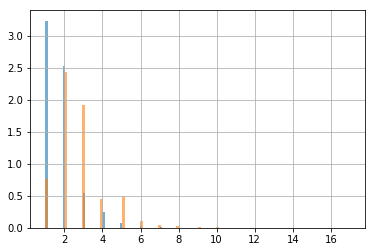

id_count


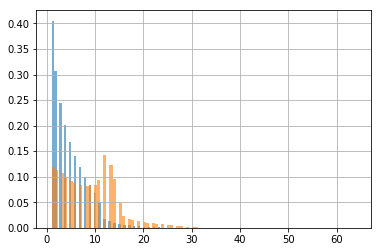

In [63]:
for col in df.columns:
    if col.startswith('f_') or col in ['target']: continue
    print col
    s1=df[col]
    s2=testx[col]
    s1=s1[s1>0]
    s2=s2[s2>0]
    s1.hist(bins=100,alpha=0.6,normed=True)
    s2.hist(bins=100,alpha=0.6,normed=True)
    plt.show()
    #break

In [16]:
trainx=df.drop(['target'],axis=1)
trainy=df['target']

In [17]:
trainx.shape

(5203955, 53)

In [18]:
5203954*.8

4163163.2

In [19]:
split = 4163163
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(testx)




Building DMatrix...


In [20]:
x_train.shape,x_valid.shape

((4163163, 53), (1040792, 53))

In [45]:
import numpy as np
from numba import jit 

def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    w = np.zeros((max_rat + 1, max_rat + 1))
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            w[i, j] = (i - j) * (i - j)/ float(max_rat * max_rat)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for i, j in zip(a1, a2):
        hist1[i] += 1
        hist2[j] += 1
        o +=  w[i, j]

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * w[i, j]

    e = e / float(a1.shape[0])

    return 1 - o / e

@jit
def qwk3(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e

def eval_qwk(preds, dtrain):
    labels = dtrain.get_label()
    preds=clip_pred(preds)
    qwk_score = qwk3(labels, preds)
    return [('qwk', qwk_score)]

In [50]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
#params['eval_metric'] = eval_qwk
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Training ...
[0]	train-rmse:4.20841	valid-rmse:4.20491	train-qwk:0.097573	valid-qwk:0.097451
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.86229	valid-rmse:1.87696	train-qwk:0.750552	valid-qwk:0.74627
[80]	train-rmse:1.8477	valid-rmse:1.87358	train-qwk:0.75503	valid-qwk:0.747846
[120]	train-rmse:1.83643	valid-rmse:1.87242	train-qwk:0.758222	valid-qwk:0.748393
[160]	train-rmse:1.82687	valid-rmse:1.87188	train-qwk:0.760939	valid-qwk:0.748725
[200]	train-rmse:1.81788	valid-rmse:1.87174	train-qwk:0.763461	valid-qwk:0.748954
[240]	train-rmse:1.80982	valid-rmse:1.87183	train-qwk:0.765632	valid-qwk:0.748856
Stopping. Best iteration:
[200]	train-rmse:1.81788	valid-rmse:1.87174	train-qwk:0.763461	valid-qwk:0.748954

CPU times: user 25min 25s, sys: 36.2 s, total: 26min 1s
Wall time: 3min 23s


In [51]:
pred=clf.predict(d_valid)
qwk3(y_valid,clip_pred(pred))

0.7488962243870989

In [52]:
pd.Series(clf.get_fscore()).sort_values()

changed_count      126
count              142
f_34               147
f_29               194
f_9                230
f_37               255
f_16               267
f_39               279
f_10               282
f_1                341
freq               351
f_2                372
f_24               401
f_20               416
f_6                448
f_31               463
mkt_count          476
latest3_mean       477
f_23               790
age                800
latest2_change     842
latest2_mean       847
f_41               870
f_38               911
f_25               965
f_40               985
f_33              1015
id_count          1036
f_32              1063
f_30              1118
f_22              1125
f_5               1150
f_12              1184
f_28              1251
f_27              1253
f_0               1320
f_26              1367
f_35              1386
f_4               1424
f_17              1435
f_14              1494
latest_target     1553
f_36              1668
f_18       

In [46]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:l1f7'
#params['eval_metric'] = eval_qwk
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Training ...
[0]	train-rmse:4.20841	valid-rmse:4.20491	train-qwk:0.097573	valid-qwk:0.097451
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.86135	valid-rmse:1.87694	train-qwk:0.750834	valid-qwk:0.74618
[80]	train-rmse:1.8464	valid-rmse:1.87346	train-qwk:0.755275	valid-qwk:0.74765
[120]	train-rmse:1.83466	valid-rmse:1.87206	train-qwk:0.758647	valid-qwk:0.748368
[160]	train-rmse:1.82447	valid-rmse:1.87177	train-qwk:0.761464	valid-qwk:0.74857
[200]	train-rmse:1.81538	valid-rmse:1.87158	train-qwk:0.764025	valid-qwk:0.748837
[240]	train-rmse:1.80704	valid-rmse:1.8717	train-qwk:0.766391	valid-qwk:0.748961
[280]	train-rmse:1.79875	valid-rmse:1.87208	train-qwk:0.768638	valid-qwk:0.748936
Stopping. Best iteration:
[250]	train-rmse:1.80483	valid-rmse:1.87179	train-qwk:0.76701	valid-qwk:0.749001

CPU times: user 29min, sys: 42.3 s, total: 29min 42s
Wall time: 3min 51s


In [47]:
pred=clf.predict(d_valid)
qwk3(y_valid,clip_pred(pred))

0.7489047597103297

In [23]:
def scale_pred(y_true, y_pred):
    B=np.mean((y_true-y_true.mean())**2)
    C=np.mean((y_pred-y_pred.mean())**2)
    A=np.mean((y_true-y_pred)**2)
    
    print A,B,C, (C-A+B)/(C+B)
    
    b=np.arange(-1,1.3,0.01)
    bb=(b*(C-A)+B)/(C+b**2*B)
    print max(bb)
    plt.plot(b,bb)
    return (B/(A-C))
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [24]:
pred=clf.predict(d_valid)

In [33]:
qwk(y_valid,clip_pred(pred))

0.7488616635995136

In [31]:
quadratic_weighted_kappa(y_valid,clip_pred(pred))

0.748861663599367

In [26]:
lst=[]
for s in np.arange(1.25,1.35,0.01):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.25, 0.7724067028540661)
(1.26, 0.7725657760493737)
(1.27, 0.7726678154261242)
(1.28, 0.7726853416512846)
(1.29, 0.772681858303232)
(1.3, 0.7726249959520315)
(1.3100000000000001, 0.7725633022090254)
(1.3200000000000001, 0.7724191084568588)
(1.3300000000000001, 0.7723127858508676)
(1.3400000000000001, 0.7721436247665853)
(1.3500000000000001, 0.7719261491917243)


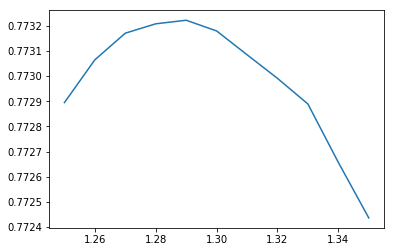

In [26]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

0.7496282226546537

In [29]:
raw_pred=clf.predict(d_train)

In [30]:
pred=clip_pred(raw_pred)
quadratic_weighted_kappa(y_train,pred)

0.7654559556845046

In [31]:
for s in np.arange(1.1,1.41,0.05):
    pred=(raw_pred-raw_pred.mean())*s+raw_pred.mean()
    pred=clip_pred(pred)
    print s, np.round(quadratic_weighted_kappa(y_train,pred),3)

1.1 0.78
1.15 0.784
1.2 0.787
1.25 0.789
1.3 0.789
1.35 0.788
1.4 0.787


# test pred

In [32]:
pred=clip_pred(clf.predict(d_test))

In [33]:
pred.shape

(1378521,)

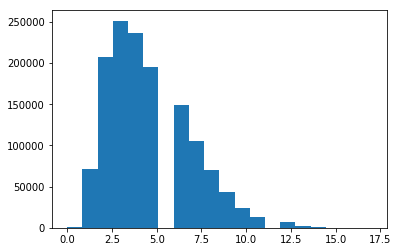

In [34]:
plt.hist(pred,bins=20);

In [35]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

/home/spark/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
sample_sub.shape

(1378521, 1)

In [37]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [38]:
this_sub=this_sub.loc[sample_sub.index]

In [39]:
this_sub.isnull().sum()

target    0
dtype: int64

In [40]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [41]:
make_submission(this_sub,"../submission/simple_xgb_combined.csv")

rm: cannot remove ‘../submission/simple_xgb_combined.csv.7z’: No such file or directory


# test pred2

In [42]:
pred=(clf.predict(d_test))

In [43]:
pred.shape

(1378521,)

In [44]:
pred.mean()

4.5412698

In [45]:
pred=(pred-pred.mean())*1.29+pred.mean()

In [46]:
pred=clip_pred(pred)

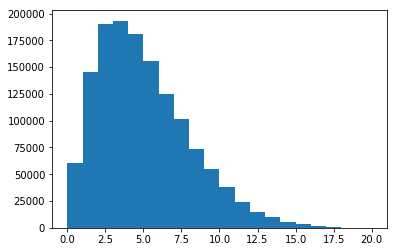

In [47]:
plt.hist(pred,bins=20);

In [48]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [49]:
sample_sub.shape

(1378521, 1)

In [50]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [51]:
this_sub=this_sub.loc[sample_sub.index]

In [52]:
this_sub.isnull().sum()

target    0
dtype: int64

In [53]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [54]:
make_submission(this_sub,"../submission/simple_xgb_combined_s1.29.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_s1.29.csv.7z’: No such file or directory
